
Copyright 2019-2022 Universidad Complutense de Madrid

This file software has been employed to reduce infrared raw data from the CIRCE camera at GTC (see [Cabello et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...659A.116C/abstract))

Authors: Cristina Cabello (criscabe@ucm.es), 
         Nicolás Cardiel (cardiel@ucm.es)
         Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+
License-Filename: LICENSE.txt


In [181]:
import numpy as np
import matplotlib.pyplot as plt

import math as m

from astropy.io import ascii
from astropy.io import fits
from astropy import units as u

import pyphot
from pyphot import Filter


from synphot import Observation, SourceSpectrum, SpectralElement
from synphot import units
from synphot.models import Empirical1D

## <span style="color:red"> FLUX CALIBRATION OF THE NB1257/CIRCE IMAGE (II) </span>

### Compute the zero-point (ZP) needed to convert units of erg s$^{-1}$ cm$^{-2}$ $\overset{\circ}{A}$ to AB magnitudes

### $\bullet$ Using the pyphot package: https://mfouesneau.github.io/docs/pyphot/

First, we load the pyphot library which contain more han 250 filters. Then, we search for our broad-band filter, the WFC3/F125W of the HST, and we print its properties:

In [182]:
lib = pyphot.get_library()
print("Library contains: ", len(lib), "filters")

Library contains:  265 filters


In [183]:
f = lib.find('HST_WFC3_F125W')
for name in f:
    lib[name].info(show_zeropoints=True)
    
f_f125w = lib['HST_WFC3_F125W']


Filter object information:
    name:                 HST_WFC3_F125W
    detector type:        photon
    wavelength units:     AA
    central wavelength:   12492.675730 angstrom
    pivot wavelength:     12462.068776 angstrom
    effective wavelength: 12279.220395 angstrom
    photon wavelength:    12339.359915 angstrom
    minimum wavelength:   10842.968750 angstrom
    maximum wavelength:   14138.864258 angstrom
    norm:                 2915.432301
    effective width:      2962.434283 angstrom
    fullwidth half-max:   3015.819336 angstrom
    definition contains 1050 points

    Zeropoints
        Vega: 23.783518 mag,
              3.066144682807507e-10 erg / angstrom * centimeter ** 2 * second,
              1588.372021885138 Jy
              189.76854392071857 photon / angstrom * centimeter ** 2 * second
          AB: 22.885899 mag,
              7.008747520975526e-10 erg / angstrom * centimeter ** 2 * second,
              3630.7805477009993 Jy
          ST: 21.100000 mag,
    

We load the transmission curve of our NB1257 filter and we use the `Filter` function to define our bandpass

In [184]:
T = ascii.read('NB1257_transmittance.txt', 'r')

wavelength = T["col1"]    # wavelength in Angstroms
transmittance = T["col2"] # transmittance normalized


f_NB = Filter((wavelength), (transmittance), name='NB1257', dtype='photon', unit='Angstrom')


Once we have defined the both the broad- and the narrow-band filters, we can obtain the zero-points:

In [185]:
print('ZP of the NB1257 filter: ', np.round(f_NB.AB_zero_mag,2))
print('ZP of the F125W filter: ', np.round(f_f125w.AB_zero_mag,2))


ZP of the NB1257 filter:  22.9
ZP of the F125W filter:  22.89


We downloaded the 1D spectra of two stars in the field (Star 3 and Star 4) from the 3D-HST survey. These spectra were taken with the HST/G141 grism.

In [186]:
filename1 = ascii.read('spec_star3_26666.ascii')
filename2 = ascii.read('spec_star4_17427.ascii')

#########

lamb_star3 = filename1['wave']   # wavelength in Angstroms
spectrum_star3 = filename1['flux']*10**-17   
 
lamb_star4 = filename2['wave']   # wavelength in Angstroms
spectrum_star4 = filename2['flux']*10**-17  


Then, we computed their synthetic magnitudes using the transmission curves of the NB1257 and F125W filters

In [187]:
print('------NB1257/CIRCE------')
print(' ')
flux_NB_star3 = f_NB.get_flux(lamb_star3, spectrum_star3 , axis=-1)
mags_NB_ab_star3 = -f_NB.AB_zero_mag  -2.5 * np.log10(flux_NB_star3 )  
print('STAR 3 Magnitude (AB): ', np.round(mags_NB_ab_star3,2))
#
flux_NB_star4 = f_NB.get_flux(lamb_star4, spectrum_star4, axis=-1)
mags_NB_ab_star4 = -f_NB.AB_zero_mag -2.5 * np.log10(flux_NB_star4) 
print('STAR 4 Magnitude (AB): ', np.round(mags_NB_ab_star4,2))


print(' ')
print('------F125W/WFC3------')
print(' ')
flux_F125W_star3 = f_f125w.get_flux(lamb_star3, spectrum_star3, axis=-1)
mags_F125W_ab_star3 = -f_f125w.AB_zero_mag  -2.5 * np.log10(flux_F125W_star3 )  
print('STAR 3 Magnitude (AB): ', np.round(mags_F125W_ab_star3,2))
#
flux_F125W_star4 = f_f125w.get_flux(lamb_star4, spectrum_star4, axis=-1)
mags_F125W_ab_star4 = -f_f125w.AB_zero_mag  -2.5 * np.log10(flux_F125W_star4) 
print('STAR 4 Magnitude (AB): ', np.round(mags_F125W_ab_star4,2))

------NB1257/CIRCE------
 
STAR 3 Magnitude (AB):  16.89
STAR 4 Magnitude (AB):  18.48
 
------F125W/WFC3------
 
STAR 3 Magnitude (AB):  16.98
STAR 4 Magnitude (AB):  18.53


###  $\bullet$ Using the synphot package : https://synphot.readthedocs.io/en/latest/


First, we define our bandpass loading the transmission curves:

In [188]:
F_NB = SpectralElement.from_file('NB1257_transmittance.txt')   # NB1257 filter
F_F125W = SpectralElement.from_file('F125W_transmittance.dat') # F125W filter

We define the spectra of the stars:

In [189]:
star3_spec = SourceSpectrum(Empirical1D, points=lamb_star3, lookup_table=spectrum_star3*units.FLAM)
star4_spec = SourceSpectrum(Empirical1D, points=lamb_star4, lookup_table=spectrum_star4*units.FLAM)

  points: [10185.11]
  lookup_table: [-3.31428872e-08] [synphot.models]
  points: [10266.8  17269.17]
  lookup_table: [-3.41819075e-08 -5.84516266e-08] [synphot.models]


We plot the transmission curves of the filters and the spectra of the two stars.

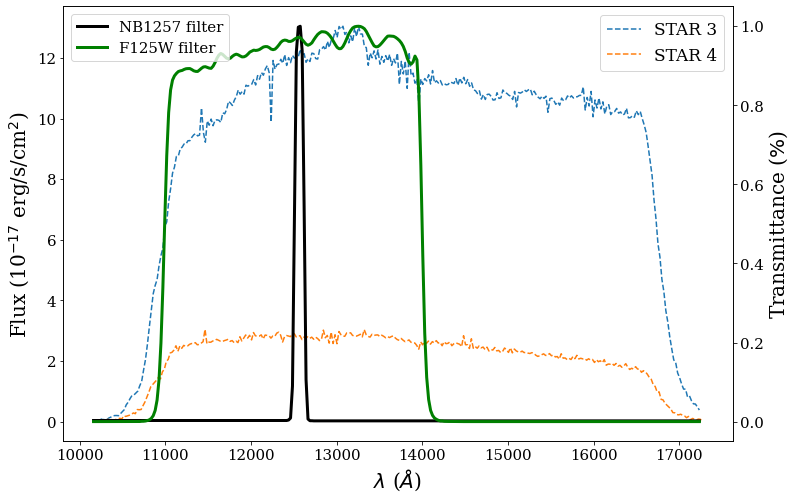

In [190]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.plot(lamb_star3, star3_spec (lamb_star3, flux_unit=units.FLAM)/10**-17, linestyle='dashed', label='STAR 3')
ax.plot(lamb_star4, star4_spec (lamb_star4, flux_unit=units.FLAM)/10**-17, linestyle='dashed', label='STAR 4')
plt.legend(loc=1,prop={'size': 17,'family':'serif'})
plt.yticks(fontname = 'serif', size=15)
plt.xticks(fontname = 'serif', size=15)
ax2 = ax.twinx()
ax2.plot(lamb_star3, F_NB(lamb_star3)/np.max(F_NB(lamb_star3)), label="NB1257 filter", linewidth=3, color='black')
ax2.plot(lamb_star3, F_F125W(lamb_star3)/np.max(F_F125W(lamb_star3)), label="F125W filter", linewidth=3, color='green')
ax.set_xlabel("$\lambda$ ($\AA$)", fontsize=20,family='serif')
ax.set_ylabel(r'Flux (10$^{-17}$ erg/s/cm$^{2}$)', fontsize=20,family='serif')
ax2.set_ylabel(r'Transmittance ($\%$)', fontsize=20,family='serif')
plt.sca(ax2)
plt.yticks(fontname = 'serif', size=15)
plt.legend(loc=2,prop={'size': 15,'family':'serif'})
plt.show()


We compute the synthetic magnitudes of the stars:

In [191]:
print('------NB1257/CIRCE------')
print(' ')
obs = Observation(star3_spec, F_NB)
NB_f_synthetic_star3 = obs.effstim(flux_unit='flam')
NBmag_synthetic_star3 = obs.effstim(flux_unit='abmag')
print("STAR 3 Magnitude: {}".format(np.round(NBmag_synthetic_star3,2)))
#
obs = Observation(star4_spec, F_NB)
NB_f_synthetic_star4 = obs.effstim(flux_unit='flam')
NBmag_synthetic_star4 = obs.effstim(flux_unit='abmag')
print("STAR 4 Magnitude: {}".format(np.round(NBmag_synthetic_star4,2)))


print(' ')
print('------F125W/WFC3------')
print(' ')
obs = Observation(star3_spec, F_F125W)
F_F125W_f_synthetic_star3 = obs.effstim(flux_unit='flam')
F_F125Wmag_synthetic_star3 = obs.effstim(flux_unit='abmag')
print("STAR 3 Magnitude: {}".format(np.round(F_F125Wmag_synthetic_star3,2)))
#
obs = Observation(star4_spec, F_F125W)
F_F125W_f_synthetic_star4 = obs.effstim(flux_unit='flam')
F_F125Wmag_synthetic_star4 = obs.effstim(flux_unit='abmag')
print("STAR 4 Magnitude: {}".format(np.round(F_F125Wmag_synthetic_star4,2)))

------NB1257/CIRCE------
 
STAR 3 Magnitude: 16.78 mag(AB)
STAR 4 Magnitude: 18.37 mag(AB)
 
------F125W/WFC3------
 
STAR 3 Magnitude: 16.98 mag(AB)
STAR 4 Magnitude: 18.52 mag(AB)


Finally, we compute the zero-points using the following expression: 

#### ZP = `mag(AB)` $ + \, 2.5 \, log($Flux(erg s$^{-1}$ cm$^{-2}$ $\overset{\circ}{A}$))



In [192]:
print('------NB1257/CIRCE------')
print(' ')
print('STAR 3 - ZP: ' , np.round(NBmag_synthetic_star3.value + 2.5 * np.log10(NB_f_synthetic_star3.value ),2))
print('STAR 4 - ZP: ' , np.round(NBmag_synthetic_star4.value + 2.5 * np.log10(NB_f_synthetic_star4.value ),2))
print(' ')
print('------F125W/WFC3------')
print(' ')
print('STAR 3 - ZP: ' , np.round(F_F125Wmag_synthetic_star3.value + 2.5 * np.log10(F_F125W_f_synthetic_star3.value ),2))
print('STAR 4 - ZP: ' , np.round(F_F125Wmag_synthetic_star4.value + 2.5 * np.log10(F_F125W_f_synthetic_star4.value ),2))

------NB1257/CIRCE------
 
STAR 3 - ZP:  -22.9
STAR 4 - ZP:  -22.9
 
------F125W/WFC3------
 
STAR 3 - ZP:  -22.89
STAR 4 - ZP:  -22.89


We obtained the same results when using `synphot` and `pyphot` , therefore we conclude that both methods are consistent to compute synthetic photometry.